In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob, os, sys

# load data

In [2]:
dtmp = np.load('SA_data.npz', allow_pickle=True)
df_param = pd.DataFrame(dtmp['df_param'])
df_info = pd.DataFrame(dtmp['df_info'])
params = dtmp['params']
paramnames = dtmp['paramnames'][:-3]# the last three are binding parameters
# paramnames = df_param[3].values
kge = dtmp['kge']

In [3]:
dtmp = np.load('SA_pyviscous_output.npz', allow_pickle=True)
sens_indx_first = dtmp['sens_indx_first']
sens_indx_total = dtmp['sens_indx_total']

In [4]:
# remove Basins without sensitivity analysis
indnosen = sens_indx_first[0,:]<0
print('Basins without sensitivity analysis:', len(indnosen))

kge = kge[:, ~indnosen]
sens_indx_first = sens_indx_first[:,~indnosen]
sens_indx_total = sens_indx_total[:,~indnosen]
df_info = df_info.loc[~indnosen]

Basins without sensitivity analysis: 627


In [5]:
# Basins with total sensitivity < 0
indneg = []
for i in range(sens_indx_total.shape[1]):
    indi = sens_indx_total[:,i]<0
    num = np.sum(indi)
    if num>0:
        # print(i, '--', num)
        indneg.append( [i, num] )

    # negative values to zero
    sens_indx_total[indi, i] = 0

# indneg = np.array(indneg)
# dtmp = sens_indx_total[:, indneg[:,0]]
# plt.plot(dtmp)
# plt.show()

In [6]:
paramnames[np.argsort(np.nanmean(-sens_indx_first, axis=1))]

array(['fff', 'FMAX', 'hksat_sf', 'sucsat_sf', 'medlynslope', 'watsat_sf',
       'n_melt_coef', 'e_ice', 'd_max',
       'precip_repartition_nonglc_all_rain_t', 'zsno',
       'interception_fraction', 'upplim_destruct_metamorph', 'kmax',
       'jmaxb0', 'slopebeta', 'zbedrock', 'cv',
       'liq_canopy_storage_scalar', 'om_frac_sf',
       'maximum_leaf_wetted_fraction', 'n_baseflow', 'bsw_sf',
       'baseflow_scalar', 'leafcn', 'accum_factor', 'taulnir'],
      dtype=object)

In [7]:
paramnames[np.argsort(np.nanmean(-sens_indx_total, axis=1))]

array(['fff', 'hksat_sf', 'FMAX', 'sucsat_sf', 'medlynslope', 'e_ice',
       'zsno', 'watsat_sf', 'd_max', 'interception_fraction',
       'n_melt_coef', 'precip_repartition_nonglc_all_rain_t', 'kmax',
       'slopebeta', 'jmaxb0', 'upplim_destruct_metamorph',
       'liq_canopy_storage_scalar', 'om_frac_sf', 'cv', 'baseflow_scalar',
       'leafcn', 'zbedrock', 'bsw_sf', 'accum_factor',
       'maximum_leaf_wetted_fraction', 'n_baseflow', 'taulnir'],
      dtype=object)

# Plot overall sensitivities

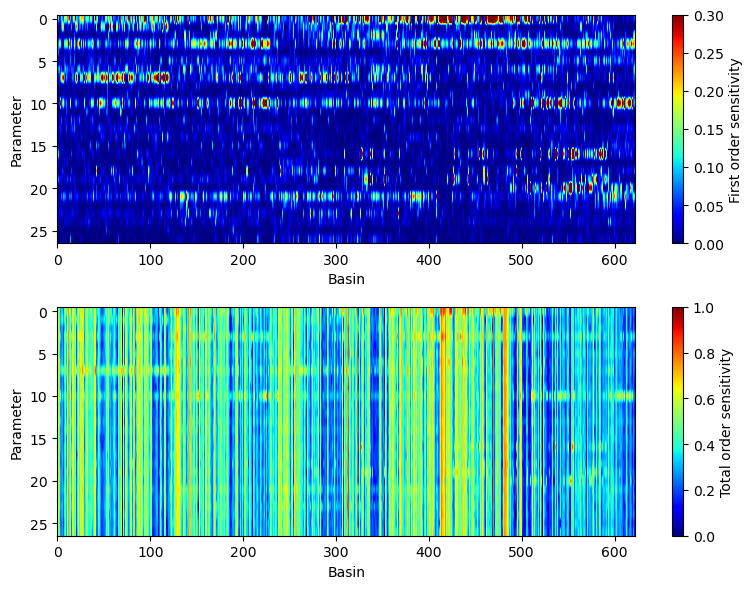

In [8]:
fig = plt.figure(figsize=[8, 6])      

ax = fig.add_subplot(2, 1, 1)
plt.imshow(sens_indx_first, aspect='auto', cmap='jet', vmin=0, vmax=0.3)
plt.xlabel('Basin')
plt.ylabel('Parameter')
plt.colorbar(label='First order sensitivity')

ax = fig.add_subplot(2, 1, 2)           
plt.imshow(sens_indx_total, aspect='auto', cmap='jet', vmin=0, vmax=1)
plt.xlabel('Basin')
plt.ylabel('Parameter')
plt.colorbar(label='Total order sensitivity')

plt.tight_layout()
plt.show()

# Compare my results and PPE results

In [11]:
# comparing rank is more reliable
rank_ind_first = np.zeros(sens_indx_first.shape)
rank_ind_total = np.zeros(sens_indx_total.shape)
for i in range(sens_indx_first.shape[1]):
    rank_ind_first[:,i] = np.argsort(np.argsort(-sens_indx_first[:,i]))
    rank_ind_total[:,i] = np.argsort(np.argsort(-sens_indx_total[:,i]))


7.868378812199037 fff
8.263242375601926 FMAX
8.985553772070626 sucsat_sf
9.186195826645266 hksat_sf
10.208667736757624 medlynslope
11.369181380417336 watsat_sf
11.658105939004816 e_ice
12.130016051364366 interception_fraction
12.298555377207062 zsno
12.617977528089888 d_max
12.975922953451043 slopebeta
13.08346709470305 kmax
13.18940609951846 jmaxb0
13.491171749598715 om_frac_sf
13.523274478330658 liq_canopy_storage_scalar
13.934189406099518 n_melt_coef
14.20545746388443 upplim_destruct_metamorph
14.215088282504013 precip_repartition_nonglc_all_rain_t
14.622792937399678 cv
15.001605136436597 bsw_sf
15.134831460674157 baseflow_scalar
15.171749598715891 zbedrock
15.18940609951846 accum_factor
15.39486356340289 leafcn
15.423756019261637 maximum_leaf_wetted_fraction
15.536115569823435 n_baseflow
16.32102728731942 taulnir


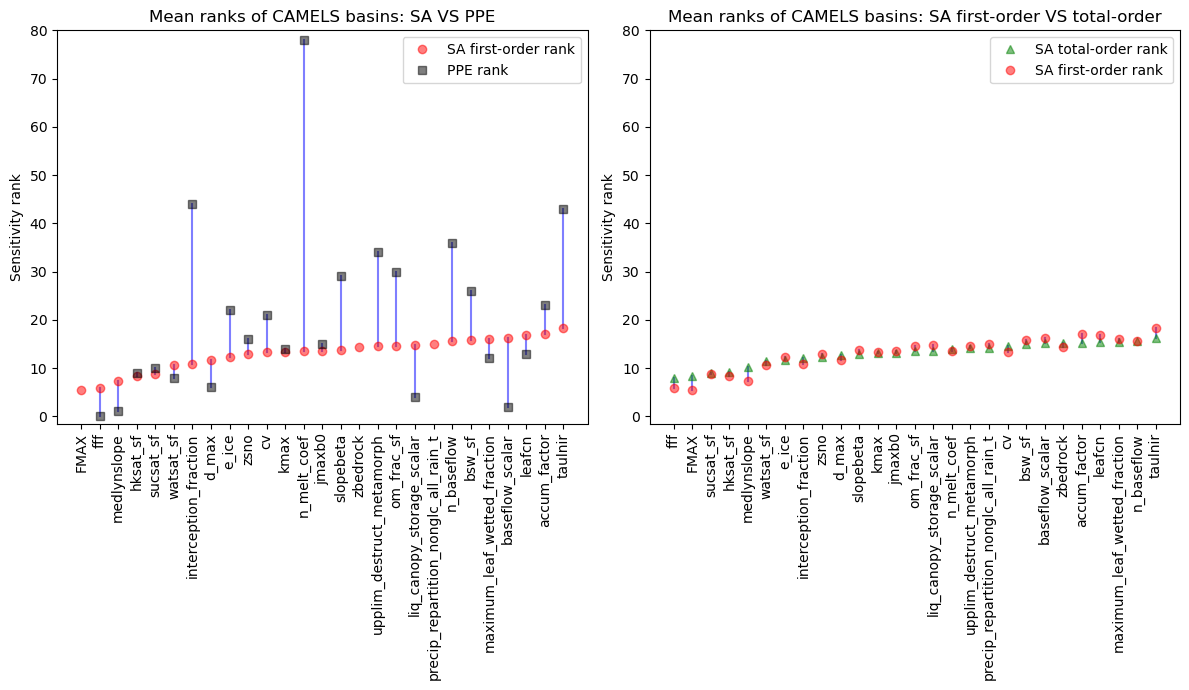

In [12]:

fig = plt.figure(figsize=[12, 7])

ax = fig.add_subplot(1, 2, 1)

rank_SAfirst = np.nanmean(rank_ind_first, axis=1)
rank_SAtotal = np.nanmean(rank_ind_total, axis=1)
rank_PPE = df_param[2].values[:-3] - 1
rank_PPE[rank_PPE < 0] = np.nan  # not used in PPE
paramnames = df_param[3].values[:-3]

# sort according to SA results
index = np.argsort(rank_SAfirst)
rank_SAfirst = rank_SAfirst[index]
rank_SAtotal = rank_SAtotal[index]
rank_PPE = rank_PPE[index]
paramnames = paramnames[index]


# Draw lines between the points
for i in range(len(paramnames)):
    plt.plot([i, i], [rank_SAfirst[i], rank_PPE[i]], 'b-', alpha=0.5)  # Draw lines between ranks

# Plot points for rank_SAfirst and rank_PPE
plt.plot(range(len(paramnames)), rank_SAfirst, 'or', alpha=0.5, label='SA first-order rank')
plt.plot(range(len(paramnames)), rank_PPE, 'sk', alpha=0.5, label='PPE rank')

plt.xticks(range(len(paramnames)), paramnames, rotation=90)  # Set x-tick labels to paramnames
plt.ylabel('Sensitivity rank')
plt.ylim(-1.5, 80)
plt.title('Mean ranks of CAMELS basins: SA VS PPE')

plt.legend()


ax = fig.add_subplot(1, 2, 2)

rank_SAfirst = np.nanmean(rank_ind_first, axis=1)
rank_SAtotal = np.nanmean(rank_ind_total, axis=1)
rank_PPE = df_param[2].values[:-3] - 1
rank_PPE[rank_PPE < 0] = np.nan  # not used in PPE
paramnames = df_param[3].values[:-3]

# sort according to SA results
index = np.argsort(rank_SAtotal)
rank_SAfirst = rank_SAfirst[index]
rank_SAtotal = rank_SAtotal[index]
rank_PPE = rank_PPE[index]
paramnames = paramnames[index]

for i, j in zip(rank_SAtotal, paramnames):
    print(i, j)


# Draw lines between the points
for i in range(len(paramnames)):
    plt.plot([i, i], [rank_SAfirst[i], rank_SAtotal[i]], 'b-', alpha=0.5)  # Draw lines between ranks

# Plot points for rank_SAfirst and rank_PPE
plt.plot(range(len(paramnames)), rank_SAtotal, '^g', alpha=0.5, label='SA total-order rank')
plt.plot(range(len(paramnames)), rank_SAfirst, 'or', alpha=0.5, label='SA first-order rank')

plt.xticks(range(len(paramnames)), paramnames, rotation=90)  # Set x-tick labels to paramnames
plt.ylabel('Sensitivity rank')
plt.ylim(-1.5, 80)
plt.title('Mean ranks of CAMELS basins: SA first-order VS total-order')

plt.legend()

plt.tight_layout()
plt.show()

In [19]:
rank_SAtotal = np.nanmean(rank_ind_total, axis=1)
paramnames = df_param[3].values[:-3]
np.argsort(np.argsort(rank_SAtotal)), paramnames

(array([ 0,  6,  9,  1, 13,  7,  5,  2, 19, 21,  3, 20, 25, 10, 14, 24, 15,
        22, 16,  8, 17,  4, 12, 11, 18, 26, 23]),
 array(['fff', 'e_ice', 'd_max', 'FMAX', 'om_frac_sf',
        'interception_fraction', 'watsat_sf', 'sucsat_sf', 'bsw_sf',
        'zbedrock', 'hksat_sf', 'baseflow_scalar', 'n_baseflow',
        'slopebeta', 'liq_canopy_storage_scalar',
        'maximum_leaf_wetted_fraction', 'n_melt_coef', 'accum_factor',
        'upplim_destruct_metamorph', 'zsno',
        'precip_repartition_nonglc_all_rain_t', 'medlynslope', 'jmaxb0',
        'kmax', 'cv', 'taulnir', 'leafcn'], dtype=object))

In [14]:
# Function to rank parameters according to their sensitivities
def rank_parameters(sensitivities):
    # Rank each parameter for each basin, higher values get lower ranks
    ranks = np.argsort(np.argsort(-sensitivities, axis=0), axis=0) + 1

    # Calculate the average rank over all basins for each parameter
    average_ranks = np.mean(ranks, axis=1)

    # Get indices of parameters from the most sensitive (lowest average rank) to the least sensitive
    sorted_indices = np.argsort(average_ranks)
    
    return sorted_indices

# Calling the function with the sensitivity index array
sorted_param_indices = rank_parameters(sens_indx_total)

# Print sorted indices of parameters from most to least sensitive
print("Indices of parameters from most sensitive to least sensitive:", sorted_param_indices)
paramnames = df_param[3].values[:-3]
paramnames[sorted_param_indices]

Indices of parameters from most sensitive to least sensitive: [ 0  3  7 10 21  6  1  5 19  2 13 23 22  4 14 16 18 20 24  8 11  9 17 26
 15 12 25]


array(['fff', 'FMAX', 'sucsat_sf', 'hksat_sf', 'medlynslope', 'watsat_sf',
       'e_ice', 'interception_fraction', 'zsno', 'd_max', 'slopebeta',
       'kmax', 'jmaxb0', 'om_frac_sf', 'liq_canopy_storage_scalar',
       'n_melt_coef', 'upplim_destruct_metamorph',
       'precip_repartition_nonglc_all_rain_t', 'cv', 'bsw_sf',
       'baseflow_scalar', 'zbedrock', 'accum_factor', 'leafcn',
       'maximum_leaf_wetted_fraction', 'n_baseflow', 'taulnir'],
      dtype=object)

# Spatial distribution of sensitivities

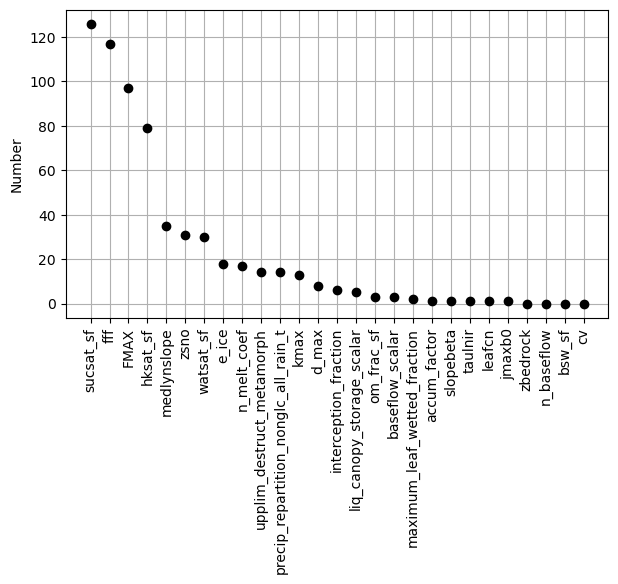

In [54]:
index = np.argmin(rank_ind_total, 0) # which parameter is the most sensitive for each basin
nparam = rank_ind_total.shape[0]
stat = np.zeros(nparam)
for i in range(nparam):
    stat[i] = np.sum(index==i)

paramnames = df_param[3].values[:-3]

inds = np.argsort(-stat)
stat = stat[inds]
paramnames = paramnames[inds]


fig = plt.figure(figsize=[7, 4])
plt.plot(range(len(paramnames)), stat, 'ok')
plt.xticks(range(len(paramnames)), paramnames, rotation=90)  # Set x-tick labels to paramnames
plt.grid('on')
plt.ylabel('Number')

plt.show()

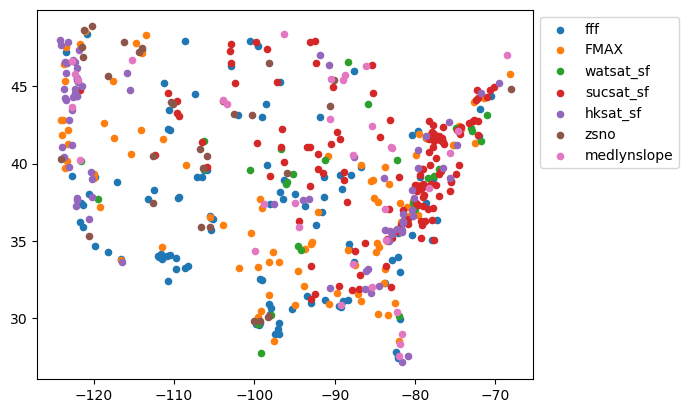

In [56]:
# For each basin, find the most sensitive parameters
# use total order rank
lat = df_info[3].values
lon = df_info[2].values

index = np.argmin(rank_ind_total, 0)
nparam = rank_ind_total.shape[0]
stat = np.zeros(nparam)
for i in range(nparam):
    stat[i] = np.sum(index==i)
paramnames = df_param[3].values[:-3]

induse = np.where(stat>=20)[0]
paramnames = paramnames[induse]

ind = np.argmin(rank_ind_total,axis=0)
for i, n in zip(induse,paramnames):
    plt.scatter(lon[ind==i], lat[ind==i], 20, label = n)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

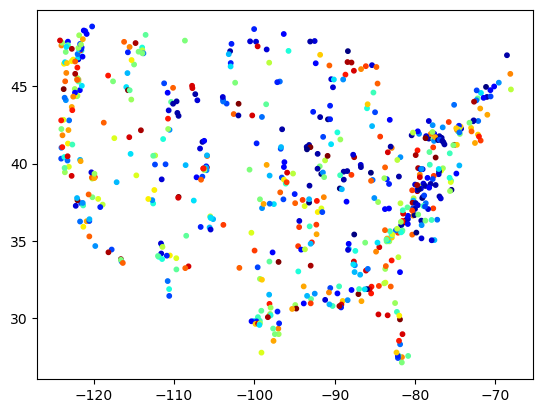

In [81]:
# For each parameter, plot its sensitivity rank in each basin
# use total order rank
lat = df_info[3].values
lon = df_info[2].values

# plt.scatter(lon, lat, 10, rank_ind_total[0,:], cmap='jet')
plt.scatter(lon, lat, 10, rank_ind_total[1,:], cmap='jet') # Why e_ice is sensitive in some florida basins? e.g., 142

In [83]:
rank_ind_total[:,142], lat[142], lon[142]

(array([ 0.,  4.,  2.,  1.,  9., 18., 12., 15.,  5., 23., 11.,  8., 26.,
        16., 13., 24.,  6., 19., 22., 25., 17.,  3., 14.,  7., 21., 20.,
        10.]),
 27.54762,
 -82.14564)

In [84]:
process_group1 = {'Infiltration': [0,1,2,3,4], 
                 'Interception': [5],
                 'Soil_storagedrainage': [6,7,8,9,10],
                 'Baseflow': [11, 12],
                 'SurfaceWater': [13],
                 'Canopy_water': [14, 15],
                 'Snow': [16, 17, 18, 19, 20],
                 'StomatalPhoto': [21, 22, 23],
                 'SensibleLatent': [24, 25],
                 'Biogeochemistry': [26]
                }
process_group2 = {'Infiltration': [0,1,2,3,4,6,7,8,9,10], 
                 'Baseflow': [11, 12],
                 'SurfaceWater': [13],
                 'Canopy_water': [5, 14, 15],
                 'Snow': [16, 17, 18, 19, 20],
                 'StomatalPhoto': [21, 22, 23],
                 'SensibleLatent': [24, 25],
                 'Biogeochemistry': [26]
                }


items = list(process_group2.items())

processrank = np.nan * np.zeros([len(items), rank_ind_total.shape[1]])
for b in range(rank_ind_total.shape[1]):
    rb = rank_ind_total[:, b]
    for i in range(len(items)):
        key, value = items[i]
        indi = [j for j in range(len(rb)) if rb[j] in value]
        processrank[i, b] = np.nanmean(indi)

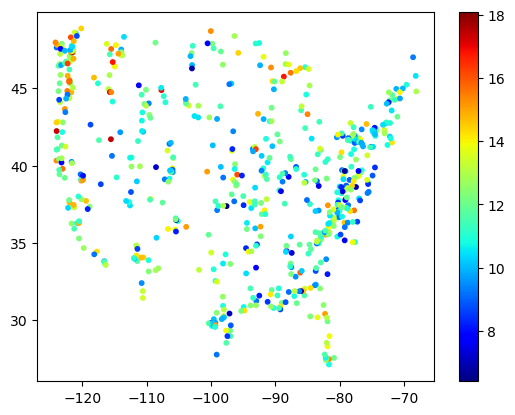

In [85]:
plt.scatter(lon, lat, 10, processrank[0], cmap='jet')
plt.colorbar()

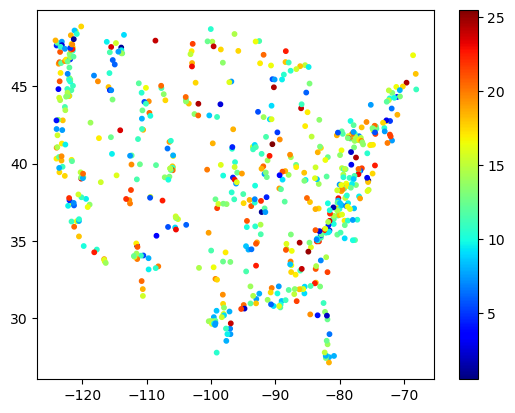

In [86]:
plt.scatter(lon, lat, 10, processrank[1], cmap='jet')
plt.colorbar()

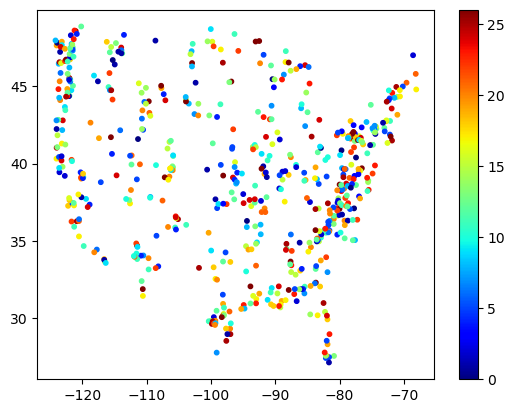

In [87]:
plt.scatter(lon, lat, 10, processrank[2], cmap='jet')
plt.colorbar()

# Check a few parameters

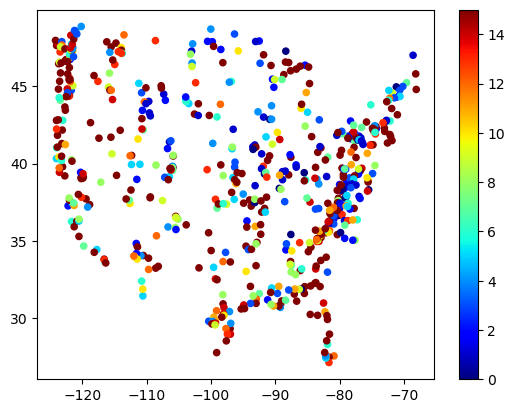

In [88]:
ind = np.where(df_param[3].values[:-3]=='e_ice')[0][0]
plt.scatter(lon, lat, 20, rank_ind_total[ind, :], cmap='jet', vmin=0, vmax=15)
plt.colorbar()
plt.show()

# Build a machine learning model

In [444]:
# df_info.iloc[[135]] # Florida
lat[135], lon[135]

(28.94932, -81.56596)

In [445]:
kgemedian = np.nanmedian(kge, axis=1)
# kgemedian = kge[:, np.argmin(lat)]
kgemedian = kge[:, 135]

induse = ~np.isnan(kgemedian)

kgemedian = kgemedian[induse]
paramsuse = params[induse, :]

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [446]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming kgemedian and paramsuse are numpy arrays with the shapes mentioned
# kgemedian.shape == (180,)
# paramsuse.shape == (180, 27)

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(paramsuse, kgemedian, test_size=0.2, random_state=42)

# Step 2: Train the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 3: Evaluate the model
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.1146219060857423


In [410]:
defa
lowerlim = df_param[5].values[:-3]
upperlim = df_param[6].values[:-3]

In [448]:
# d1 = X_test[0][np.newaxis,:]
# d2 = d1.copy()
# d2[0,1] = 1 # e_ice
# d3 = d1.copy()
# d3[0,1] = 7

d1 = X_test[0][np.newaxis,:]
d2 = d1.copy()
d2[0,0] = 0.05
d3 = d1.copy()
d3[0,0] = 4

rf.predict(d1), rf.predict(d2), rf.predict(d3), 

(array([-0.06452162]), array([-0.98352006]), array([-0.06818157]))

In [425]:
df_param

,0,1,2,3,4,5,6,7,8,9
0,Hydrology,Infiltration\nSoil storage,1,fff,0.5,0.02,5.0,Same,Param,None
1,Hydrology,Infiltration,23,e_ice,6.0,0.1,8.0,Low0to0.1,Param,None
2,Hydrology,Infiltration,7,d_max,15.0,10.0,60.0,Same,Param,None
3,Hydrology,Infiltration,0,FMAX,0.381669,0.1,0.9,NotInPPE,Surfdata,None
4,Hydrology,Infiltration\nGroundwater flow,31,om_frac_sf,1.0,0.8,1.2,Same,Param,None
5,Hydrology,Canopy Interception,45,interception_fraction,1.0,0.1,1.0,Low0.5to0.1,Namelist,None
6,Hydrology,Soil storage capacity,9,watsat_sf,1.0,0.8,1.2,Same,Param,None
7,Hydrology,Soil storage capacity,11,sucsat_sf,1.0,0.1,10.0,Same,Param,None
8,Hydrology,Soil storage capacity,27,bsw_sf,1.0,0.8,1.2,Same,Param,None
9,Hydrology,Soil storage capacity,0,zbedrock,10.639669,8.512,12.768,Same,Surfdata,None


In [450]:
sens_indx_total[:,135]

array([0.42603188, 0.31252648, 0.3304258 , 0.31705537, 0.34987348,
       0.4002559 , 0.36089815, 0.3229662 , 0.29530261, 0.32845859,
       0.32521608, 0.33247004, 0.33927166, 0.32169985, 0.39719266,
       0.33653349, 0.31288207, 0.31938726, 0.31101984, 0.32444113,
       0.33247356, 0.46561582, 0.3908637 , 0.32907909, 0.32644687,
       0.32746499, 0.33258453])

In [451]:
rank_ind_total[:,135]

array([21.,  0.,  5., 14., 22.,  6.,  4., 12., 15., 26., 20., 11.,  2.,
       23.,  9., 25., 24., 10., 19.,  7., 13., 17.,  3., 16.,  1., 18.,
        8.])